In [1]:
import pandas as pd
import numpy as np
import os
import wrangle
import explore
import model
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import sqrt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression 
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.pipeline import make_pipeline

In [2]:
def new_zillow_db():
    '''The function uses the get_connection function to connect to a database and retrieve the zillow dataset'''
    
    zillow = pd.read_sql('''SELECT p.bathroomcnt, p.bedroomcnt, p.calculatedfinishedsquarefeet,
    p.fips, p.lotsizesquarefeet, p.regionidcity, p.regionidcounty, p.regionidzip, p.yearbuilt, 
    p.taxvaluedollarcnt, pd.transactiondate, pd.logerror
    FROM properties_2017 as p

    JOIN predictions_2017 as pd
    on p.id = pd.id
    LEFT JOIN propertylandusetype USING(propertylandusetypeid)

    WHERE propertylandusedesc IN ("Single Family Residential",                       
                              "Inferred Single Family Residential")
    AND pd.transactiondate BETWEEN "2017-01-01" AND "2017-12-31"
    ;''', wrangle.get_connection('zillow'))
    return zillow


In [3]:
df = new_zillow_db()

In [4]:
df

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt,transactiondate,logerror
0,0.0,0.0,NaN,6037.0,4083.0,37688.0,3101.0,96337.0,NaN,27516.0,2017-01-01,0.055619
1,0.0,0.0,NaN,6037.0,11975.0,40227.0,3101.0,97329.0,NaN,10.0,2017-01-02,0.008669
2,0.0,0.0,NaN,6037.0,9403.0,40227.0,3101.0,97330.0,NaN,10.0,2017-01-02,-0.021896
3,0.0,0.0,NaN,6037.0,3817.0,40227.0,3101.0,97330.0,NaN,2108.0,2017-01-02,-0.017167
4,2.0,4.0,3633.0,6037.0,9826.0,40227.0,3101.0,97329.0,2005.0,296425.0,2017-01-02,0.042463
...,...,...,...,...,...,...,...,...,...,...,...,...
56074,2.0,2.0,1362.0,6037.0,6854.0,40227.0,3101.0,97330.0,1996.0,127276.0,2017-09-19,0.001082
56075,2.0,3.0,1600.0,6037.0,6709.0,40227.0,3101.0,97330.0,1992.0,180715.0,2017-09-20,-0.002245
56076,3.0,4.0,1921.0,6037.0,6763.0,40227.0,3101.0,97330.0,1990.0,162019.0,2017-09-20,0.020615
56077,3.0,4.0,1780.0,6037.0,6822.0,40227.0,3101.0,97330.0,1989.0,125923.0,2017-09-21,0.013209


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56079 entries, 0 to 56078
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   56079 non-null  float64
 1   bedroomcnt                    56079 non-null  float64
 2   calculatedfinishedsquarefeet  55848 non-null  float64
 3   fips                          56079 non-null  float64
 4   lotsizesquarefeet             55729 non-null  float64
 5   regionidcity                  55025 non-null  float64
 6   regionidcounty                56079 non-null  float64
 7   regionidzip                   55979 non-null  float64
 8   yearbuilt                     55830 non-null  float64
 9   taxvaluedollarcnt             56071 non-null  float64
 10  transactiondate               56079 non-null  object 
 11  logerror                      56079 non-null  float64
dtypes: float64(11), object(1)
memory usage: 5.1+ MB


In [6]:
df = df.dropna()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54553 entries, 4 to 56078
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   54553 non-null  float64
 1   bedroomcnt                    54553 non-null  float64
 2   calculatedfinishedsquarefeet  54553 non-null  float64
 3   fips                          54553 non-null  float64
 4   lotsizesquarefeet             54553 non-null  float64
 5   regionidcity                  54553 non-null  float64
 6   regionidcounty                54553 non-null  float64
 7   regionidzip                   54553 non-null  float64
 8   yearbuilt                     54553 non-null  float64
 9   taxvaluedollarcnt             54553 non-null  float64
 10  transactiondate               54553 non-null  object 
 11  logerror                      54553 non-null  float64
dtypes: float64(11), object(1)
memory usage: 5.4+ MB


In [8]:
df.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt,logerror
count,54553.000000,54553.000000,54553.000000,54553.000000,5.455300e+04,54553.000000,54553.000000,54553.000000,54553.000000,5.455300e+04,54553.000000
mean,2.237686,3.298517,1857.693784,6048.856177,1.123118e+04,35502.566018,2560.631918,96594.523436,1960.796253,4.525896e+05,0.016783
std,0.989100,0.931808,955.170666,21.280432,9.141415e+04,54204.959656,786.841412,4323.250953,21.698743,5.892449e+05,0.172213
min,0.000000,0.000000,20.000000,6037.000000,1.690000e+02,3491.000000,1286.000000,95982.000000,1862.000000,9.000000e+00,-4.655420
25%,2.000000,3.000000,1260.000000,6037.000000,5.686000e+03,12447.000000,2061.000000,96193.000000,1949.000000,1.866290e+05,-0.024437
50%,2.000000,3.000000,1624.000000,6037.000000,6.790000e+03,24832.000000,3101.000000,96389.000000,1958.000000,3.271200e+05,0.006741
75%,3.000000,4.000000,2200.000000,6059.000000,8.600000e+03,44116.000000,3101.000000,96987.000000,1975.000000,5.288470e+05,0.039486
max,20.000000,25.000000,26345.000000,6111.000000,6.971010e+06,396556.000000,3101.000000,399675.000000,2016.000000,3.016684e+07,5.262999


In [9]:
df.bedroomcnt = df.bedroomcnt.astype(int)
    # change year built to an integer
df.yearbuilt = df.yearbuilt.astype(int)
    # change fips to an integer
df.fips = df.fips.astype(int)
    # rename columns for readability
df = df.rename(columns={'bedroomcnt': 'bedrooms', 'bathroomcnt': 'bathrooms', 'calculatedfinishedsquarefeet': 'sqft', 
                        'taxvaluedollarcnt': 'tax_value', 'yearbuilt': 'year'})

In [10]:
df = df.rename(columns={'lotsizesquarefeet':'lot_size', 'regionidzip':'zipcode','regionidcounty':'county',
                        'regionidcity':'city'})

In [11]:
df

,bathrooms,bedrooms,sqft,fips,lot_size,city,county,zipcode,year,tax_value,transactiondate,logerror
4,2.0,4,3633.0,6037,9826.0,40227.0,3101.0,97329.0,2005,296425.0,2017-01-02,0.042463
7,2.0,3,2077.0,6037,6490.0,26964.0,3101.0,96152.0,1926,646760.0,2017-01-02,-0.040807
11,0.0,0,1200.0,6037,4054.0,12447.0,3101.0,96020.0,1972,5328.0,2017-01-02,0.069858
14,0.0,0,171.0,6037,13002.0,46298.0,3101.0,96246.0,1973,6920.0,2017-01-02,0.020950
15,0.0,0,203.0,6037,17359.0,46298.0,3101.0,96236.0,1960,14166.0,2017-01-02,0.033233
...,...,...,...,...,...,...,...,...,...,...,...,...
56074,2.0,2,1362.0,6037,6854.0,40227.0,3101.0,97330.0,1996,127276.0,2017-09-19,0.001082
56075,2.0,3,1600.0,6037,6709.0,40227.0,3101.0,97330.0,1992,180715.0,2017-09-20,-0.002245
56076,3.0,4,1921.0,6037,6763.0,40227.0,3101.0,97330.0,1990,162019.0,2017-09-20,0.020615
56077,3.0,4,1780.0,6037,6822.0,40227.0,3101.0,97330.0,1989,125923.0,2017-09-21,0.013209


In [12]:
df.describe()

,bathrooms,bedrooms,sqft,fips,lot_size,city,county,zipcode,year,tax_value,logerror
count,54553.000000,54553.000000,54553.000000,54553.000000,5.455300e+04,54553.000000,54553.000000,54553.000000,54553.000000,5.455300e+04,54553.000000
mean,2.237686,3.298517,1857.693784,6048.856177,1.123118e+04,35502.566018,2560.631918,96594.523436,1960.796253,4.525896e+05,0.016783
std,0.989100,0.931808,955.170666,21.280432,9.141415e+04,54204.959656,786.841412,4323.250953,21.698743,5.892449e+05,0.172213
min,0.000000,0.000000,20.000000,6037.000000,1.690000e+02,3491.000000,1286.000000,95982.000000,1862.000000,9.000000e+00,-4.655420
25%,2.000000,3.000000,1260.000000,6037.000000,5.686000e+03,12447.000000,2061.000000,96193.000000,1949.000000,1.866290e+05,-0.024437
50%,2.000000,3.000000,1624.000000,6037.000000,6.790000e+03,24832.000000,3101.000000,96389.000000,1958.000000,3.271200e+05,0.006741
75%,3.000000,4.000000,2200.000000,6059.000000,8.600000e+03,44116.000000,3101.000000,96987.000000,1975.000000,5.288470e+05,0.039486
max,20.000000,25.000000,26345.000000,6111.000000,6.971010e+06,396556.000000,3101.000000,399675.000000,2016.000000,3.016684e+07,5.262999


In [13]:
df = df[df['bedrooms'] < 5]
#     # remove rows with 6 or more bathrooms
df = df[df['bathrooms'] < 4]
#     # remove rows with values less than or equal to 700 square feet
df = df[df.sqft > 1000]
#     # remove rows with values greater than or equal to 10_000 square feet
df = df[df.sqft < 4000]
# remove rows with tax values greater than or equal to 600000
df = df[df.tax_value < 800000]
# remove rows with tax values less than or equal to 1000
df = df[df.tax_value > 90000]
#     # remove rows with a year less than or equal to 1899
# df = df[df.year > 1899]
df = df[df.bathrooms > 0]
df = df[df.bedrooms > 0]

In [14]:
df = df[df.lot_size < 12000]
df = df[df.lot_size > 1000]

(array([4005., 5020., 5563., 4684., 4033., 3163., 2186., 1586., 1167.,
         803.]),
 array([ 90005. , 160959.3, 231913.6, 302867.9, 373822.2, 444776.5,
        515730.8, 586685.1, 657639.4, 728593.7, 799548. ]),
 <BarContainer object of 10 artists>)

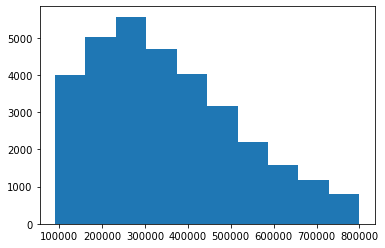

In [15]:
plt.hist(df.tax_value)

(array([ 527.,  788., 1302., 4408., 8767., 8002., 4083., 2018., 1406.,
         909.]),
 array([ 1010. ,  2108.9,  3207.8,  4306.7,  5405.6,  6504.5,  7603.4,
         8702.3,  9801.2, 10900.1, 11999. ]),
 <BarContainer object of 10 artists>)

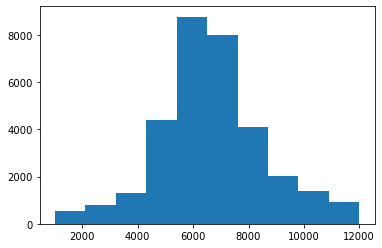

In [16]:
plt.hist(df.lot_size)

In [17]:
df.describe()

,bathrooms,bedrooms,sqft,fips,lot_size,city,county,zipcode,year,tax_value,logerror
count,32210.000000,32210.000000,32210.000000,32210.000000,32210.000000,32210.000000,32210.000000,32210.000000,32210.000000,32210.000000,32210.000000
mean,2.095017,3.211518,1669.782738,6049.463893,6694.857311,35237.199690,2522.147314,96558.506209,1961.186122,351363.281000,0.016958
std,0.597893,0.643993,481.969862,21.454723,1896.527350,53669.538456,802.527657,404.305565,20.018932,168298.699538,0.171299
min,1.000000,1.000000,1001.000000,6037.000000,1010.000000,3491.000000,1286.000000,95982.000000,1885.000000,90005.000000,-4.655420
25%,2.000000,3.000000,1299.000000,6037.000000,5592.000000,12447.000000,1286.000000,96212.000000,1950.000000,219580.000000,-0.024416
50%,2.000000,3.000000,1570.000000,6037.000000,6550.000000,24832.000000,3101.000000,96424.000000,1959.000000,324441.000000,0.006737
75%,2.500000,4.000000,1936.000000,6059.000000,7675.000000,42967.000000,3101.000000,96995.000000,1974.000000,460000.000000,0.039561
max,3.500000,4.000000,3992.000000,6111.000000,11999.000000,396556.000000,3101.000000,97330.000000,2015.000000,799548.000000,3.394544


In [18]:
df = df.drop(columns=['zipcode','city','transactiondate','logerror'])

In [19]:
def plot_residuals(y, yhat):
    '''This function takes in two arguments, y (target variable) and yhat (model predictions) and returns a 
    scatterplot of the residuals of the target variable.'''
    residuals = y - yhat
    plt.scatter(x=y, y=residuals)
    plt.xlabel('Home Value')
    plt.ylabel('Residuals')
    plt.title('Residuals for Home Value')
    plt.show()

In [20]:
train, validate, test = wrangle.split_data(df)

<AxesSubplot:xlabel='bedrooms', ylabel='count'>

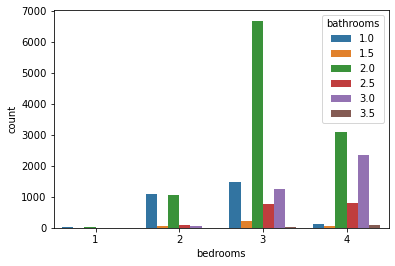

In [21]:
sns.countplot(train.bedrooms, hue=train.bathrooms)

<AxesSubplot:xlabel='fips', ylabel='count'>

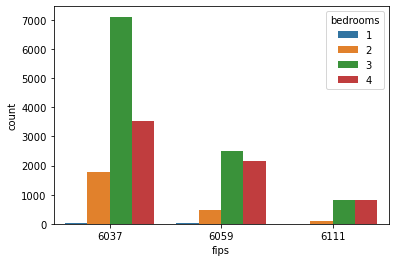

In [22]:
sns.countplot(train.fips, hue=train.bedrooms)

<AxesSubplot:xlabel='sqft', ylabel='lot_size'>

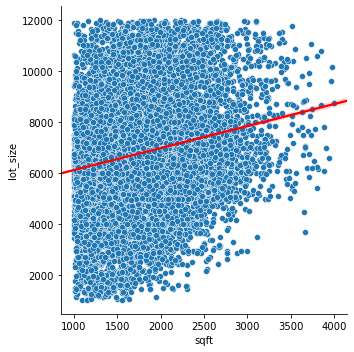

In [23]:
sns.relplot(train.sqft, train.lot_size)
sns.regplot(x='sqft', y='lot_size', data=train, truncate=False, scatter=False, color='red')

<AxesSubplot:xlabel='sqft', ylabel='tax_value'>

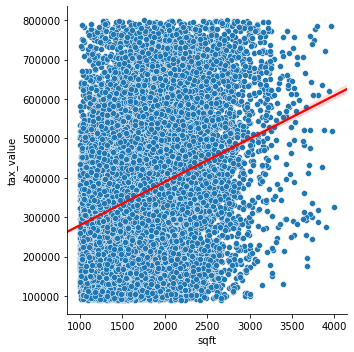

In [24]:
sns.relplot(train.sqft, train.tax_value)
sns.regplot(x='sqft', y='tax_value', data=train, truncate=False, scatter=False, color='red')

<AxesSubplot:xlabel='lot_size', ylabel='tax_value'>

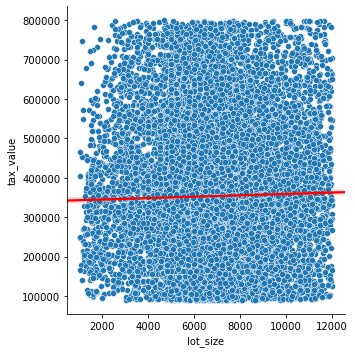

In [25]:
sns.relplot(train.lot_size, train.tax_value)
sns.regplot(x='lot_size', y='tax_value', data=train, truncate=False, scatter=False, color='red')

<AxesSubplot:xlabel='sqft', ylabel='Count'>

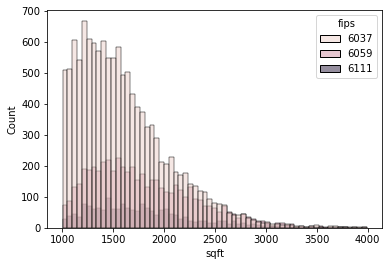

In [26]:
sns.histplot(x=train.sqft, hue=train.fips)

<AxesSubplot:xlabel='tax_value', ylabel='Count'>

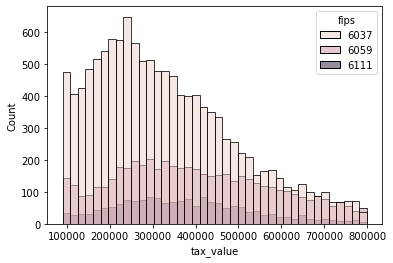

In [27]:
sns.histplot(x=train.tax_value, hue=train.fips)

<AxesSubplot:xlabel='tax_value', ylabel='Count'>

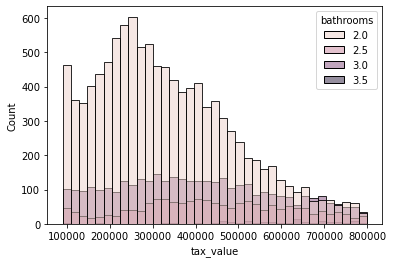

In [28]:
sns.histplot(x=train.tax_value, hue=train.bathrooms[train.bathrooms >= 2])

<AxesSubplot:xlabel='tax_value', ylabel='Count'>

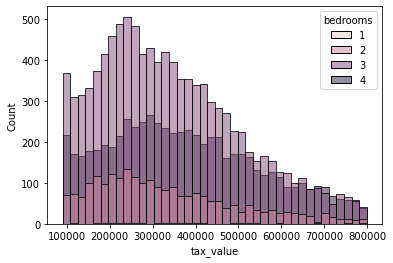

In [29]:
sns.histplot(x=train.tax_value, hue=train.bedrooms)

<AxesSubplot:xlabel='sqft', ylabel='Count'>

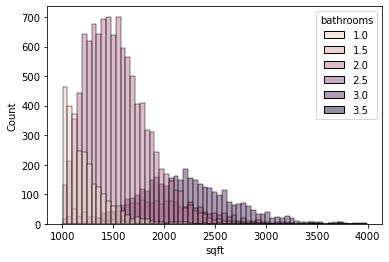

In [30]:
sns.histplot(x=train.sqft, hue=train.bathrooms)

In [31]:
cols = ['bathrooms','bedrooms','sqft']
X_train, y_train = train[cols], train.tax_value
X_validate, y_validate = validate[cols], validate.tax_value
X_test, y_test = test[cols], test.tax_value

In [32]:
baseline = train.tax_value.mean()

In [33]:
train['baseline'] = baseline

In [34]:
train

,bathrooms,bedrooms,sqft,fips,lot_size,county,year,tax_value,baseline
33806,2.0,3,1681.0,6037,6959.0,3101.0,1956,353537.0,353307.021474
34268,2.0,4,1654.0,6037,7496.0,3101.0,1980,176299.0,353307.021474
28434,1.0,2,1338.0,6037,6521.0,3101.0,1953,461934.0,353307.021474
47024,1.0,2,1050.0,6037,3335.0,3101.0,1915,744637.0,353307.021474
13023,3.0,3,1792.0,6037,7019.0,3101.0,1984,197973.0,353307.021474
...,...,...,...,...,...,...,...,...,...
50902,2.0,2,1122.0,6059,3276.0,1286.0,1986,151372.0,353307.021474
750,2.0,4,2040.0,6111,8940.0,2061.0,1975,442053.0,353307.021474
50269,3.0,3,1505.0,6037,2871.0,3101.0,1997,168589.0,353307.021474
54143,2.0,3,2558.0,6111,8775.0,2061.0,1957,497472.0,353307.021474


In [35]:
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.minmax_scaler(X_train, X_validate, X_test)

In [36]:
ols_model = LinearRegression().fit(X_train_scaled, train.tax_value)

In [37]:
train['yhat'] = ols_model.predict(X_train_scaled)

In [38]:
y = train.tax_value
yhat = train.yhat

In [39]:
# create column for model residual error
train['residual'] = train.yhat - train.tax_value
# create column for baseline residual error
train['residual_baseline'] = train.baseline - train.tax_value

In [40]:
# calculate the model's sum of squares error for the selected variables against the target variable
SSE = mean_squared_error(train.tax_value, train.yhat)*len(train)
# calculate the baseline's sum of squares error for the selected variables against the target variable
SSE_baseline = mean_squared_error(train.tax_value, train.baseline)*len(train)
# calculate the model mean squared error for the selected variables against the target variable
MSE = mean_squared_error(train.tax_value, train.yhat)
# calculate the baseline mean squared error for the selected variables against the target variable
MSE_baseline = mean_squared_error(train.tax_value, train.baseline)
# calculate the model root mean squared error for the selected variables against the target variable
RMSE = sqrt(mean_squared_error(train.tax_value, train.yhat))
# calculate the baseline root mean squared error for the selected variables against the target variable
RMSE_baseline = sqrt(mean_squared_error(train.tax_value, train.baseline))

In [41]:
# create a dataframe for the model SSE, MSE, RMSE
train_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
# create a dataframe to show the baseline SSE, MSE, RMSE
train_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])
# add a column to the train_eval dataframe for the values associated with each model metric
train_eval['model_error'] = np.array([SSE, MSE, RMSE])
# add a column to the train_baseline_eval for the values associated with each baseline metric
train_baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])
# print the dataframes
print(train_eval)
print(train_baseline_eval)

  metric   model_error
0    SSE  4.941814e+14
1    MSE  2.557081e+10
2   RMSE  1.599087e+05
          metric   model_error
0   SSE_baseline  5.504865e+14
1   MSE_baseline  2.848424e+10
2  RMSE_baseline  1.687728e+05


In [42]:
# add a column to train_eval for the error delta for each metric
train_eval['error_delta'] = train_eval.model_error - train_baseline_eval.model_error
train_eval

,metric,model_error,error_delta
0,SSE,4.941814e+14,-5.630505e+13
1,MSE,2.557081e+10,-2.913435e+09
2,RMSE,1.599087e+05,-8.864007e+03


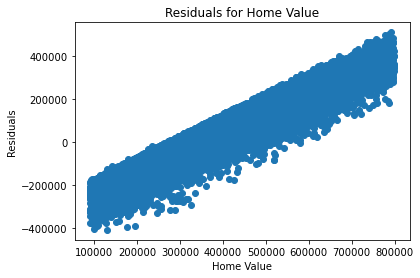

In [43]:
plot_residuals(y, yhat)

In [44]:
cols = ['bathrooms','sqft','year','fips']
X_train, y_train = train[cols], train.tax_value
X_validate, y_validate = validate[cols], validate.tax_value
X_test, y_test = test[cols], test.tax_value

In [45]:
baseline = train.tax_value.mean()

In [46]:
train['baseline'] = baseline
validate['baseline'] = validate.tax_value.mean()

In [47]:
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.minmax_scaler(X_train, X_validate, X_test)

In [48]:
ols_model = LinearRegression().fit(X_train_scaled, train.tax_value)

In [49]:
train['yhat'] = ols_model.predict(X_train_scaled)

In [50]:
y = train.tax_value
yhat = train.yhat

In [51]:
# create column for model residual error
train['residual'] = train.yhat - train.tax_value
# create column for baseline residual error
train['residual_baseline'] = train.baseline - train.tax_value

In [52]:
# calculate the model's sum of squares error for the selected variables against the target variable
SSE = mean_squared_error(train.tax_value, train.yhat)*len(train)
# calculate the baseline's sum of squares error for the selected variables against the target variable
SSE_baseline = mean_squared_error(train.tax_value, train.baseline)*len(train)
# calculate the model mean squared error for the selected variables against the target variable
MSE = mean_squared_error(train.tax_value, train.yhat)
# calculate the baseline mean squared error for the selected variables against the target variable
MSE_baseline = mean_squared_error(train.tax_value, train.baseline)
# calculate the model root mean squared error for the selected variables against the target variable
RMSE = sqrt(mean_squared_error(train.tax_value, train.yhat))
# calculate the baseline root mean squared error for the selected variables against the target variable
RMSE_baseline = sqrt(mean_squared_error(train.tax_value, train.baseline))

In [53]:
# create a dataframe for the model SSE, MSE, RMSE
train_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
# create a dataframe to show the baseline SSE, MSE, RMSE
train_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])
# add a column to the train_eval dataframe for the values associated with each model metric
train_eval['model_error'] = np.array([SSE, MSE, RMSE])
# add a column to the train_baseline_eval for the values associated with each baseline metric
train_baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])
# print the dataframes
print(train_eval)
print(train_baseline_eval)

  metric   model_error
0    SSE  4.932268e+14
1    MSE  2.552141e+10
2   RMSE  1.597542e+05
          metric   model_error
0   SSE_baseline  5.504865e+14
1   MSE_baseline  2.848424e+10
2  RMSE_baseline  1.687728e+05


In [54]:
# add a column to train_eval for the error delta for each metric
train_eval['error_delta'] = train_eval.model_error - train_baseline_eval.model_error
train_eval

,metric,model_error,error_delta
0,SSE,4.932268e+14,-5.725966e+13
1,MSE,2.552141e+10,-2.962830e+09
2,RMSE,1.597542e+05,-9.018530e+03


In [55]:
r2_score(train.tax_value, train.yhat)

0.10401646946638943

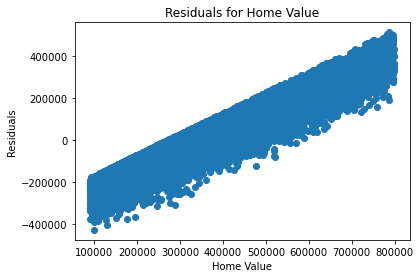

In [56]:
plot_residuals(y, yhat)

In [57]:
df.fips = df.fips.astype(str)

In [58]:
df.county = df.county.astype(str)

In [59]:
# create dummies for the 'day' and 'time' columns
dummy_df = pd.get_dummies(df[['fips', 'county']], dummy_na=False)
# concatenate the dummy columns and the original dataframe
df = pd.concat([df, dummy_df], axis=1)

In [60]:
df

,bathrooms,bedrooms,sqft,fips,lot_size,county,year,tax_value,fips_6037,fips_6059,fips_6111,county_1286.0,county_2061.0,county_3101.0
4,2.0,4,3633.0,6037,9826.0,3101.0,2005,296425.0,1,0,0,0,0,1
7,2.0,3,2077.0,6037,6490.0,3101.0,1926,646760.0,1,0,0,0,0,1
18,1.0,3,1244.0,6037,6021.0,3101.0,1950,169471.0,1,0,0,0,0,1
19,2.0,3,1300.0,6037,4917.0,3101.0,1950,233266.0,1,0,0,0,0,1
20,2.0,3,1222.0,6037,5500.0,3101.0,1951,290492.0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56074,2.0,2,1362.0,6037,6854.0,3101.0,1996,127276.0,1,0,0,0,0,1
56075,2.0,3,1600.0,6037,6709.0,3101.0,1992,180715.0,1,0,0,0,0,1
56076,3.0,4,1921.0,6037,6763.0,3101.0,1990,162019.0,1,0,0,0,0,1
56077,3.0,4,1780.0,6037,6822.0,3101.0,1989,125923.0,1,0,0,0,0,1


In [61]:
df['bed_bath'] = df.bathrooms + df.bedrooms

In [62]:
df.fips = df.fips.astype(int)

In [63]:
df.county = df.county.astype(float)

In [64]:
train, validate, test = wrangle.split_data(df)

In [65]:
train.describe()

,bathrooms,bedrooms,sqft,fips,lot_size,county,year,tax_value,fips_6037,fips_6059,fips_6111,county_1286.0,county_2061.0,county_3101.0,bed_bath
count,19326.000000,19326.000000,19326.000000,19326.000000,19326.000000,19326.000000,19326.000000,19326.000000,19326.000000,19326.000000,19326.000000,19326.000000,19326.000000,19326.000000,19326.000000
mean,2.096166,3.211684,1673.084808,6049.552520,6701.334472,2525.109231,1961.161906,353307.021474,0.643951,0.265290,0.090759,0.265290,0.090759,0.643951,5.307850
std,0.599268,0.648094,482.887558,21.629906,1896.753727,800.295762,20.033217,168777.121583,0.478842,0.441499,0.287273,0.441499,0.287273,0.478842,1.062283
min,1.000000,1.000000,1001.000000,6037.000000,1024.000000,1286.000000,1885.000000,90005.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,2.000000,3.000000,1300.000000,6037.000000,5596.250000,1286.000000,1950.000000,220923.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
50%,2.000000,3.000000,1572.000000,6037.000000,6560.000000,3101.000000,1959.000000,327409.500000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000
75%,2.500000,4.000000,1940.000000,6059.000000,7688.000000,3101.000000,1974.000000,462904.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,6.000000
max,3.500000,4.000000,3992.000000,6111.000000,11999.000000,3101.000000,2015.000000,799548.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.500000


In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19326 entries, 33806 to 5167
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bathrooms      19326 non-null  float64
 1   bedrooms       19326 non-null  int64  
 2   sqft           19326 non-null  float64
 3   fips           19326 non-null  int64  
 4   lot_size       19326 non-null  float64
 5   county         19326 non-null  float64
 6   year           19326 non-null  int64  
 7   tax_value      19326 non-null  float64
 8   fips_6037      19326 non-null  uint8  
 9   fips_6059      19326 non-null  uint8  
 10  fips_6111      19326 non-null  uint8  
 11  county_1286.0  19326 non-null  uint8  
 12  county_2061.0  19326 non-null  uint8  
 13  county_3101.0  19326 non-null  uint8  
 14  bed_bath       19326 non-null  float64
dtypes: float64(6), int64(3), uint8(6)
memory usage: 1.6 MB


In [67]:
cols = ['bathrooms','sqft','fips_6037','bed_bath','bedrooms','lot_size','year']
X_train, y_train = train[cols], train[['tax_value']]
X_validate, y_validate = validate[cols], validate[['tax_value']]
X_test, y_test = test[cols], test[['tax_value']]

In [68]:
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.quantile_scaler(X_train, X_validate, X_test)

In [69]:
baseline = train.tax_value.mean()

In [70]:
train['baseline'] = baseline

In [71]:
validate['baseline'] = validate.tax_value.mean()

In [72]:
ols_model = LinearRegression().fit(X_train_scaled, train.tax_value)

In [73]:
train['yhat'] = ols_model.predict(X_train_scaled)

In [74]:
y = train.tax_value
yhat = train.yhat

In [75]:
# create column for model residual error
train['residual'] = train.yhat - train.tax_value
# create column for baseline residual error
train['residual_baseline'] = train.baseline - train.tax_value

In [76]:
# calculate the model's sum of squares error for the selected variables against the target variable
SSE = mean_squared_error(train.tax_value, train.yhat)*len(train)
# calculate the baseline's sum of squares error for the selected variables against the target variable
SSE_baseline = mean_squared_error(train.tax_value, train.baseline)*len(train)
# calculate the model mean squared error for the selected variables against the target variable
MSE = mean_squared_error(train.tax_value, train.yhat)
# calculate the baseline mean squared error for the selected variables against the target variable
MSE_baseline = mean_squared_error(train.tax_value, train.baseline)
# calculate the model root mean squared error for the selected variables against the target variable
RMSE = sqrt(mean_squared_error(train.tax_value, train.yhat))
# calculate the baseline root mean squared error for the selected variables against the target variable
RMSE_baseline = sqrt(mean_squared_error(train.tax_value, train.baseline))

In [77]:
# create a dataframe for the model SSE, MSE, RMSE
train_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
# create a dataframe to show the baseline SSE, MSE, RMSE
train_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])
# add a column to the train_eval dataframe for the values associated with each model metric
train_eval['model_error'] = np.array([SSE, MSE, RMSE])
# add a column to the train_baseline_eval for the values associated with each baseline metric
train_baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])
# print the dataframes
print(train_eval)
print(train_baseline_eval)

  metric   model_error
0    SSE  4.887639e+14
1    MSE  2.529049e+10
2   RMSE  1.590298e+05
          metric   model_error
0   SSE_baseline  5.504865e+14
1   MSE_baseline  2.848424e+10
2  RMSE_baseline  1.687728e+05


In [78]:
# add a column to train_eval for the error delta for each metric
train_eval['error_delta'] = train_eval.model_error - train_baseline_eval.model_error
train_eval

,metric,model_error,error_delta
0,SSE,4.887639e+14,-6.172256e+13
1,MSE,2.529049e+10,-3.193757e+09
2,RMSE,1.590298e+05,-9.742929e+03


In [79]:
r2_score(train.tax_value, train.yhat)

0.11212365491443044

In [80]:
X = X_train
y = y_train

In [81]:
def select_kbest(X, y, k=2):
    '''
    will take in two pandas objects:
    X: a dataframe representing numerical independent features
    y: a pandas Series representing a target variable
    k: a keyword argument defaulted to 2 for the number of ideal features we elect to select
    
    return: a list of the selected features from the SelectKBest process
    '''
    kbest = SelectKBest(f_regression, k=k)
    kbest.fit(X, y)
    mask = kbest.get_support()
    return X.columns[mask]

In [82]:
select_kbest(X, y, k=5)

Index(['bathrooms', 'sqft', 'fips_6037', 'bed_bath', 'year'], dtype='object')

In [83]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_pred_lars)**(1/2)

# predict validate
y_validate['tax_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  159033.22451247528 
Validation/Out-of-Sample:  156935.51587208445


In [84]:
train['yhat'] = lars.predict(X_train_scaled)

In [85]:
y = train.tax_value
yhat = train.yhat

In [86]:
# create column for model residual error
train['residual'] = train.yhat - train.tax_value
# create column for baseline residual error
train['residual_baseline'] = train.baseline - train.tax_value

In [87]:
# calculate the model's sum of squares error for the selected variables against the target variable
SSE = mean_squared_error(train.tax_value, train.yhat)*len(train)
# calculate the baseline's sum of squares error for the selected variables against the target variable
SSE_baseline = mean_squared_error(train.tax_value, train.baseline)*len(train)
# calculate the model mean squared error for the selected variables against the target variable
MSE = mean_squared_error(train.tax_value, train.yhat)
# calculate the baseline mean squared error for the selected variables against the target variable
MSE_baseline = mean_squared_error(train.tax_value, train.baseline)
# calculate the model root mean squared error for the selected variables against the target variable
RMSE = sqrt(mean_squared_error(train.tax_value, train.yhat))
# calculate the baseline root mean squared error for the selected variables against the target variable
RMSE_baseline = sqrt(mean_squared_error(train.tax_value, train.baseline))

In [88]:
# create a dataframe for the model SSE, MSE, RMSE
train_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
# create a dataframe to show the baseline SSE, MSE, RMSE
train_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])
# add a column to the train_eval dataframe for the values associated with each model metric
train_eval['model_error'] = np.array([SSE, MSE, RMSE])
# add a column to the train_baseline_eval for the values associated with each baseline metric
train_baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])
# print the dataframes
print(train_eval)
print(train_baseline_eval)

  metric   model_error
0    SSE  4.887848e+14
1    MSE  2.529157e+10
2   RMSE  1.590332e+05
          metric   model_error
0   SSE_baseline  5.504865e+14
1   MSE_baseline  2.848424e+10
2  RMSE_baseline  1.687728e+05


In [89]:
# add a column to train_eval for the error delta for each metric
train_eval['error_delta'] = train_eval.model_error - train_baseline_eval.model_error
train_eval

,metric,model_error,error_delta
0,SSE,4.887848e+14,-6.170166e+13
1,MSE,2.529157e+10,-3.192676e+09
2,RMSE,1.590332e+05,-9.739530e+03


In [90]:
r2_score(train.tax_value, train.yhat)

0.11208570063765566

In [91]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [92]:
# create the model object
lm2 = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_lm2)**(1/2)

# predict validate
y_validate['value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  172939.86356047026 
Validation/Out-of-Sample:  171046.54726365206


In [93]:
train['yhat'] = lm2.predict(X_train_degree2)

In [94]:
y = train.tax_value
yhat = train.yhat

In [95]:
# calculate the model's sum of squares error for the selected variables against the target variable
SSE = mean_squared_error(train.tax_value, train.yhat)*len(train)
# calculate the baseline's sum of squares error for the selected variables against the target variable
SSE_baseline = mean_squared_error(train.tax_value, train.baseline)*len(train)
# calculate the model mean squared error for the selected variables against the target variable
MSE = mean_squared_error(train.tax_value, train.yhat)
# calculate the baseline mean squared error for the selected variables against the target variable
MSE_baseline = mean_squared_error(train.tax_value, train.baseline)
# calculate the model root mean squared error for the selected variables against the target variable
RMSE = sqrt(mean_squared_error(train.tax_value, train.yhat))
# calculate the baseline root mean squared error for the selected variables against the target variable
RMSE_baseline = sqrt(mean_squared_error(train.tax_value, train.baseline))

In [96]:
# create a dataframe for the model SSE, MSE, RMSE
train_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
# create a dataframe to show the baseline SSE, MSE, RMSE
train_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])
# add a column to the train_eval dataframe for the values associated with each model metric
train_eval['model_error'] = np.array([SSE, MSE, RMSE])
# add a column to the train_baseline_eval for the values associated with each baseline metric
train_baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])
# print the dataframes
print(train_eval)
print(train_baseline_eval)

  metric   model_error
0    SSE  5.780058e+14
1    MSE  2.990820e+10
2   RMSE  1.729399e+05
          metric   model_error
0   SSE_baseline  5.504865e+14
1   MSE_baseline  2.848424e+10
2  RMSE_baseline  1.687728e+05


In [97]:
# add a column to train_eval for the error delta for each metric
train_eval['error_delta'] = train_eval.model_error - train_baseline_eval.model_error
train_eval

,metric,model_error,error_delta
0,SSE,5.780058e+14,2.751933e+13
1,MSE,2.990820e+10,1.423954e+09
2,RMSE,1.729399e+05,4.167109e+03


In [98]:
r2_score(train.tax_value, train.yhat)

-0.049990923270902377

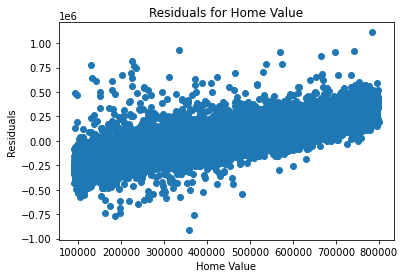

In [99]:
plot_residuals(y, yhat)

In [100]:
# create the model object
glm = TweedieRegressor(power=1, alpha=5)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['value_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_glm)**(1/2)

# predict validate
y_validate['value_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=2 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=2 & alpha=0
Training/In-Sample:  158703.8370635266 
Validation/Out-of-Sample:  156651.1689310095


In [101]:
train['yhat'] = glm.predict(X_train_scaled)

In [102]:
y = train.tax_value
yhat = train.yhat

In [103]:
# calculate the model's sum of squares error for the selected variables against the target variable
SSE = mean_squared_error(train.tax_value, train.yhat)*len(train)
# calculate the baseline's sum of squares error for the selected variables against the target variable
SSE_baseline = mean_squared_error(train.tax_value, train.baseline)*len(train)
# calculate the model mean squared error for the selected variables against the target variable
MSE = mean_squared_error(train.tax_value, train.yhat)
# calculate the baseline mean squared error for the selected variables against the target variable
MSE_baseline = mean_squared_error(train.tax_value, train.baseline)
# calculate the model root mean squared error for the selected variables against the target variable
RMSE = sqrt(mean_squared_error(train.tax_value, train.yhat))
# calculate the baseline root mean squared error for the selected variables against the target variable
RMSE_baseline = sqrt(mean_squared_error(train.tax_value, train.baseline))

In [104]:
# create a dataframe for the model SSE, MSE, RMSE
train_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
# create a dataframe to show the baseline SSE, MSE, RMSE
train_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])
# add a column to the train_eval dataframe for the values associated with each model metric
train_eval['model_error'] = np.array([SSE, MSE, RMSE])
# add a column to the train_baseline_eval for the values associated with each baseline metric
train_baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])
# print the dataframes
print(train_eval)
print(train_baseline_eval)

  metric   model_error
0    SSE  4.867622e+14
1    MSE  2.518691e+10
2   RMSE  1.587038e+05
          metric   model_error
0   SSE_baseline  5.504865e+14
1   MSE_baseline  2.848424e+10
2  RMSE_baseline  1.687728e+05


In [105]:
# add a column to train_eval for the error delta for each metric
train_eval['error_delta'] = train_eval.model_error - train_baseline_eval.model_error
train_eval

,metric,model_error,error_delta
0,SSE,4.867622e+14,-6.372429e+13
1,MSE,2.518691e+10,-3.297335e+09
2,RMSE,1.587038e+05,-1.006892e+04


In [106]:
r2_score(train.tax_value, train.yhat)

0.11575996366235985

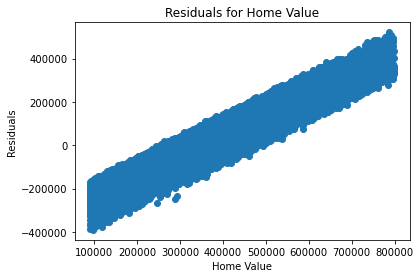

In [107]:
plot_residuals(y, yhat)

In [108]:
# create column for model residual error
train['residual'] = train.yhat - train.tax_value
# create column for baseline residual error
train['residual_baseline'] = train.baseline - train.tax_value

In [109]:
ols_model = LinearRegression().fit(X_validate_scaled, validate.tax_value)

In [110]:
validate['yhat'] = ols_model.predict(X_validate_scaled)

In [111]:
y = validate.tax_value
yhat = validate.yhat

In [112]:
# create column for model residual error
validate['residual'] = validate.yhat - validate.tax_value
# create column for baseline residual error
validate['residual_baseline'] = validate.baseline - validate.tax_value

In [113]:
# calculate the model's sum of squares error for the selected variables against the target variable
SSE = mean_squared_error(validate.tax_value, validate.yhat)*len(validate)
# calculate the baseline's sum of squares error for the selected variables against the target variable
SSE_baseline = mean_squared_error(validate.tax_value, validate.baseline)*len(validate)
# calculate the model mean squared error for the selected variables against the target variable
MSE = mean_squared_error(validate.tax_value, validate.yhat)
# calculate the baseline mean squared error for the selected variables against the target variable
MSE_baseline = mean_squared_error(validate.tax_value, validate.baseline)
# calculate the model root mean squared error for the selected variables against the target variable
RMSE = sqrt(mean_squared_error(validate.tax_value, validate.yhat))
# calculate the baseline root mean squared error for the selected variables against the target variable
RMSE_baseline = sqrt(mean_squared_error(validate.tax_value, validate.baseline))

In [114]:
# create a dataframe for the model SSE, MSE, RMSE
e_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
# create a dataframe to show the baseline SSE, MSE, RMSE
baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])
# add a column to the train_eval dataframe for the values associated with each model metric
e_eval['model_error'] = np.array([SSE, MSE, RMSE])
# add a column to the train_baseline_eval for the values associated with each baseline metric
baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])
# print the dataframes
print(e_eval)
print(baseline_eval)

  metric   model_error
0    SSE  1.583967e+14
1    MSE  2.458812e+10
2   RMSE  1.568060e+05
          metric   model_error
0   SSE_baseline  1.787778e+14
1   MSE_baseline  2.775191e+10
2  RMSE_baseline  1.665891e+05


In [115]:
# add a column to train_eval for the error delta for each metric
e_eval['error_delta'] = e_eval.model_error - baseline_eval.model_error
e_eval

,metric,model_error,error_delta
0,SSE,1.583967e+14,-2.038113e+13
1,MSE,2.458812e+10,-3.163790e+09
2,RMSE,1.568060e+05,-9.783048e+03


In [116]:
r2_score(validate.tax_value, validate.yhat)

0.11400257037306494

In [117]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_pred_lars)**(1/2)

# predict validate
y_validate['tax_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  159033.22451247528 
Validation/Out-of-Sample:  156935.51587208445


In [118]:
train['yhat'] = lars.predict(X_train_scaled)

In [119]:
y = train.tax_value
yhat = train.yhat

In [120]:
# create column for model residual error
train['residual'] = train.yhat - train.tax_value
# create column for baseline residual error
train['residual_baseline'] = train.baseline - train.tax_value

In [121]:
# calculate the model's sum of squares error for the selected variables against the target variable
SSE = mean_squared_error(train.tax_value, train.yhat)*len(train)
# calculate the baseline's sum of squares error for the selected variables against the target variable
SSE_baseline = mean_squared_error(train.tax_value, train.baseline)*len(train)
# calculate the model mean squared error for the selected variables against the target variable
MSE = mean_squared_error(train.tax_value, train.yhat)
# calculate the baseline mean squared error for the selected variables against the target variable
MSE_baseline = mean_squared_error(train.tax_value, train.baseline)
# calculate the model root mean squared error for the selected variables against the target variable
RMSE = sqrt(mean_squared_error(train.tax_value, train.yhat))
# calculate the baseline root mean squared error for the selected variables against the target variable
RMSE_baseline = sqrt(mean_squared_error(train.tax_value, train.baseline))

In [122]:
# create a dataframe for the model SSE, MSE, RMSE
train_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
# create a dataframe to show the baseline SSE, MSE, RMSE
train_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])
# add a column to the train_eval dataframe for the values associated with each model metric
train_eval['model_error'] = np.array([SSE, MSE, RMSE])
# add a column to the train_baseline_eval for the values associated with each baseline metric
train_baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])
# print the dataframes
print(train_eval)
print(train_baseline_eval)

  metric   model_error
0    SSE  4.887848e+14
1    MSE  2.529157e+10
2   RMSE  1.590332e+05
          metric   model_error
0   SSE_baseline  5.504865e+14
1   MSE_baseline  2.848424e+10
2  RMSE_baseline  1.687728e+05


In [123]:
# add a column to train_eval for the error delta for each metric
train_eval['error_delta'] = train_eval.model_error - train_baseline_eval.model_error
train_eval

,metric,model_error,error_delta
0,SSE,4.887848e+14,-6.170166e+13
1,MSE,2.529157e+10,-3.192676e+09
2,RMSE,1.590332e+05,-9.739530e+03


In [124]:
r2_score(train.tax_value, train.yhat)

0.11208570063765566

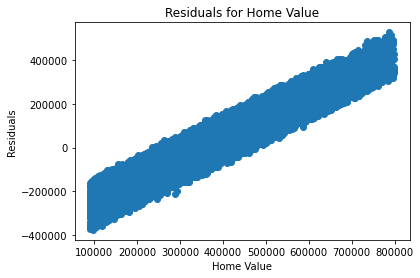

In [125]:
plot_residuals(y, yhat)

In [126]:
model.lasso_lars_model(X_train_scaled, X_validate_scaled, y_train, y_validate, train, 1)

RMSE for Lasso + Lars
Training/In-Sample:  159033.22451247528 
Validation/Out-of-Sample:  156935.51587208445 
r^2 score:  0.11208570063765566


In [127]:
model.lrm(X_train_scaled, X_validate_scaled, y_train, y_validate, train)

RMSE for Linear Regression Model 
Training/In-Sample:  159029.825504526 
Validation/Out-of-Sample:  156925.77845831972 
r^2 score:  0.11212365491443044


In [130]:
model.poly_lm(X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, train, 2)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  157578.45618450915 
Validation/Out-of-Sample:  155280.51094180654 
r^2 score:  0.12825592669527897


In [129]:
model.glm_model(X_train_scaled, X_validate_scaled, y_train, y_validate, train, 1, 2)

RMSE for GLM using Tweedie, power=1 & alpha=2
Training/In-Sample:  158703.86409798404 
Validation/Out-of-Sample:  156651.06987978527 
r^2 score:  0.11575966241001323


In [238]:
y = lrm(X_train_scaled, X_validate_scaled, y_train, y_validate, train)

In [239]:
z = lrm(X_train_scaled, X_validate_scaled, y_train, y_validate, train)

In [248]:
def model_performance(df1, df2, df3):
    df1 = x
    df2 = y
    df3 = z
    df = df1.merge('left', on=df2)
    return df

In [257]:
def train_vars(cols):
    cols = cols
    X_train, y_train = train[cols], train.tax_value
    return X_train, y_train

In [258]:
cols = ['bathrooms','bedrooms','sqft']
X_train, y_train = train_vars(cols)

In [259]:
def val_vars(cols):
    cols = cols
    X_validate, y_validate = validate[cols], validate.tax_value
    return X_validate, y_validate

In [260]:
X_validate, y_validate = val_vars(cols)

In [264]:
def model_vars(cols):
    cols = cols
    X_train, y_train, X_validate, y_validate, X_test, y_test = train[cols], train.tax_value, validate[cols], validate.tax_value, test[cols], test.tax_value
    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [265]:
cols = ['bathrooms','bedrooms','sqft','year']

In [267]:
X_train, y_train, X_validate, y_validate, X_test, y_test = model_vars(cols)

In [268]:
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.minmax_scaler(X_train, X_validate, X_test)